#### Tournament

every so often a tournament is held batch updating the rankings then readjusting the portfolio according to those rankings.

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import pandas as pd

from src.eval import Evaluation
from src.rating import Elo_Player, Glicko2_Player
from src.tools import generate_returns

In [172]:
# generate data

symbols = ['SPY', 'TLT']
symbols_prime = symbols

# load assets
S = yf.download(symbols,
                start=dt.datetime(2004, 1, 1),
                end=dt.datetime(2024, 7, 26))['Close']
S = pd.DataFrame(S)

#S['INSURANCE'] = np.ones(len(S))

mS = S.resample('M').last()
wS = S.resample('W').last()

dat_ = S.copy()

[*********************100%%**********************]  2 of 2 completed


In [173]:
dat_ = S.values.T
dat_

array([[111.23000336, 112.44000244, 112.55000305, ..., 553.7800293 ,
        541.22998047, 538.40997314],
       [ 84.44000244,  84.22000122,  85.15000153, ...,  92.51999664,
         91.51999664,  92.26999664]])

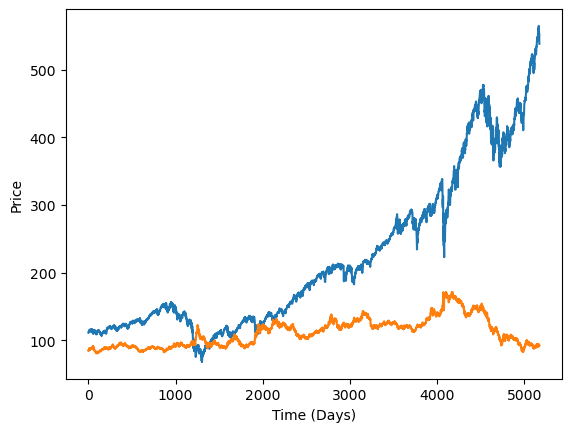

In [174]:
for i in dat_:
    plt.plot(i)

plt.ylabel('Price')
plt.xlabel('Time (Days)')
plt.show()

In [175]:
# generate returns
returns = generate_returns(arr=dat_)

In [176]:
# Calculate the average return across assets for each time period
portfolio_returns = np.mean(returns, axis=0)

# Calculate the cumulative returns
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

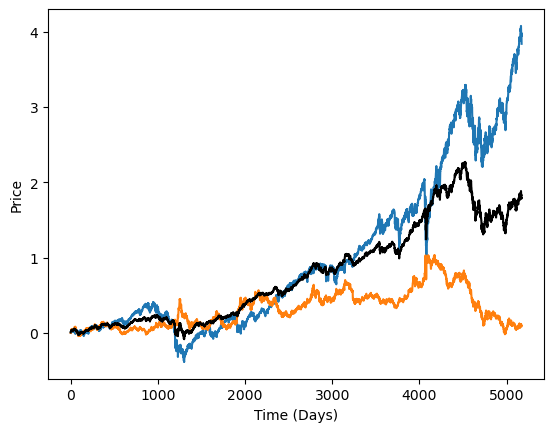

In [177]:
for i in range(0, returns.shape[0]):
    plt.plot(np.cumprod(1 + returns[i]) - 1)

plt.plot(cumulative_returns, color='black')
plt.ylabel('Price')
plt.xlabel('Time (Days)')
plt.show()

In [178]:
returns = returns.T
returns.shape


(5174, 2)

In [179]:
returns

array([[ 0.01087835, -0.00260541],
       [ 0.0009783 ,  0.01104251],
       [ 0.00337625,  0.00399291],
       ...,
       [-0.00156855, -0.00140318],
       [-0.02266252, -0.01080847],
       [-0.00521037,  0.00819493]])

In [180]:
# pairwise comparisons to get win/loss array

# Create the win_loss_arr with the correct shape (time, assets, assets)
win_loss_arr = np.zeros((returns.shape[0], returns.shape[1], returns.shape[1]))

# Initialize ratings array with the first time step ratings set to 1500
ratings = np.zeros((returns.shape[0], returns.shape[1]))
ratings[0] = 1500

# Initialize Elo_Player instances for each asset
players = [Elo_Player(rating=1500) for _ in range(returns.shape[1])]


for t in range(returns.shape[0]):
    # daily tournament
    for i in range(returns.shape[1]):
        for j in range(returns.shape[1]):
            if i == j:
                win_loss_arr[t, i, j] = np.nan
            else:
                win_loss_arr[t, i, j] = Evaluation.above_below_equal(s1=returns[t, i], s2=returns[t, j])


    # Update ratings using online_update
    for i in range(returns.shape[1]):
        outcomes = []
        opponent_ratings = []
        for j in range(returns.shape[1]):
            if i != j:
                outcomes.append(win_loss_arr[t, i, j])
                opponent_ratings.append(players[j].get_rating())

        players[i].online_update(outcomes=outcomes, ratings=opponent_ratings)
        ratings[t,i] = players[i].get_rating()


print("Shape of win_loss_arr:", win_loss_arr.shape)
print("win_loss_arr example slice for time t=0:\n", win_loss_arr[0])

Shape of win_loss_arr: (5174, 2, 2)
win_loss_arr example slice for time t=0:
 [[nan  1.]
 [ 0. nan]]


In [181]:
players[0].get_rating()

1442.3506206116076

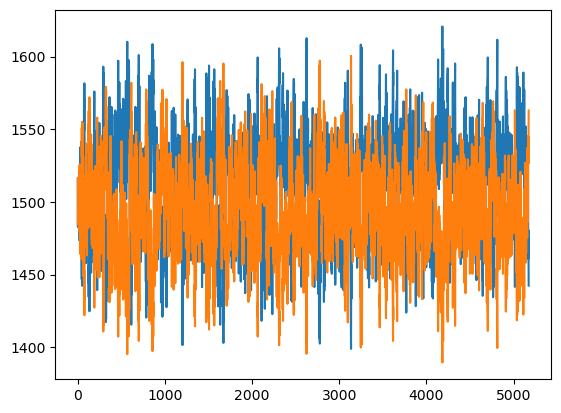

In [182]:
# get elo ratings
for i in range(0, ratings.shape[1]):
    plt.plot(ratings[:,i])
plt.show()

In [183]:
# Assuming Elo_Player and Evaluation classes are already defined and the code to update ratings is executed

def rank_players_over_time(ratings):
    """
    Rank players from best to worst over time.

    Parameters:
    ratings (np.ndarray): Array of player ratings with shape (time, players)

    Returns:
    np.ndarray: Array of player rankings with shape (time, players), where each row contains the ranked indices of players
    """
    rankings = np.zeros_like(ratings, dtype=int)

    for t in range(ratings.shape[0]):
        rankings[t] = np.argsort(-ratings[t])

    return rankings

In [184]:
# rank players
rankings = rank_players_over_time(ratings)

print("Rankings example for time t=0:\n", rankings[0])


Rankings example for time t=0:
 [0 1]


In [192]:
def calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2, invert=False):
    """
    Calculate the portfolio returns by shorting the bottom X% and going long on the top Y% of players.

    Parameters:
    returns (np.ndarray): Array of player returns with shape (time, players)
    long_pct (float): Percentage of players to go long on (top Y%)
    short_pct (float): Percentage of players to short (bottom X%)

    Returns:
    np.ndarray: Array of cumulative portfolio returns over time
    """

    n_players = returns.shape[1]

    long_count = int(n_players * long_pct)
    short_count = int(n_players * short_pct)

    portfolio_returns = np.zeros(returns.shape[0] - 1)  # One less because of the offset

    for t in range(returns.shape[0] - 1):  # Adjust the loop to avoid index out of range
        if invert is False:
            top_indices = rankings[t, :long_count]
            bottom_indices = rankings[t, -short_count:]
        else:
            top_indices = rankings[t, -short_count:]
            bottom_indices = rankings[t, :long_count]

        long_returns = np.mean(returns[t + 1, top_indices])
        short_returns = np.mean(returns[t + 1, bottom_indices])

        # Portfolio return: long returns minus short returns
        portfolio_returns[t] = long_returns - short_returns

    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

    return cumulative_returns

In [186]:
def calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2, invert=False):
    """
    Calculate the portfolio returns by shorting the bottom X% and going long on the top Y% of players.

    Parameters:
    rankings (np.ndarray): Array of player rankings with shape (time, players)
    returns (np.ndarray): Array of player returns with shape (time, players)
    long_pct (float): Percentage of players to go long on (top Y%)
    short_pct (float): Percentage of players to short (bottom X%)
    invert (bool): Whether to invert the rankings for long and short positions

    Returns:
    np.ndarray: Array of cumulative portfolio returns over time
    """

    n_players = returns.shape[1]

    # Ensure the long and short positions are balanced
    balanced_long_pct = long_pct / (long_pct + short_pct)
    balanced_short_pct = short_pct / (long_pct + short_pct)

    long_count = int(n_players * balanced_long_pct)
    short_count = int(n_players * balanced_short_pct)

    portfolio_returns = np.zeros(returns.shape[0] - 1)  # One less because of the offset

    for t in range(returns.shape[0] - 1):  # Adjust the loop to avoid index out of range
        if invert is False:
            top_indices = rankings[t, :long_count]
            bottom_indices = rankings[t, -short_count:]
        else:
            top_indices = rankings[t, -short_count:]
            bottom_indices = rankings[t, :long_count]

        long_returns = np.mean(returns[t + 1, top_indices])
        short_returns = np.mean(returns[t + 1, bottom_indices])

        # Portfolio return: long returns minus short returns
        portfolio_returns[t] = long_returns - short_returns

    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

    return cumulative_returns

In [193]:
cumulative_returns_strat = calculate_long_short_returns(rankings, returns, long_pct=0.5, short_pct=0.5, invert=False)

cumulative_returns_strat_invert = calculate_long_short_returns(rankings, returns, long_pct=0.5, short_pct=0.5, invert=True)


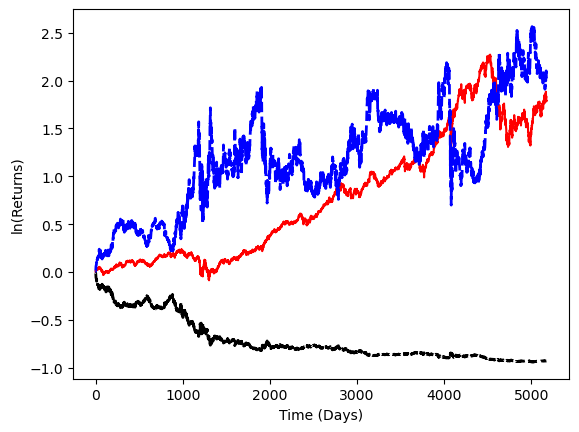

In [194]:
plt.plot(cumulative_returns, color='red')
plt.plot(cumulative_returns_strat, color='black', linestyle='--', linewidth=2)
plt.plot(cumulative_returns_strat_invert, color='blue', linestyle='--', linewidth=2)
plt.ylabel('ln(Returns)')
plt.xlabel('Time (Days)')
plt.show()

In [189]:
# pairwise comparisons to get win/loss array

# Create the win_loss_arr with the correct shape (time, assets, assets)
win_loss_arr = np.zeros((returns.shape[0], returns.shape[1], returns.shape[1]))

# Initialize ratings array with the first time step ratings set to 1500
ratings = np.zeros((returns.shape[0], returns.shape[1]))
rds = np.zeros((returns.shape[0], returns.shape[1]))
ratings[0] = 1500
rds[0] = 350

# Initialize Elo_Player instances for each asset
players = [Glicko2_Player() for _ in range(returns.shape[1])]


for t in range(returns.shape[0]):
    # daily tournament
    for i in range(returns.shape[1]):
        for j in range(returns.shape[1]):
            if i == j:
                win_loss_arr[t, i, j] = np.nan
            else:
                win_loss_arr[t, i, j] = Evaluation.above_below_equal(s1=returns[t, i], s2=returns[t, j])


    # Update ratings using online_update
    for i in range(returns.shape[1]):
        outcomes = []
        opponent_ratings = []
        opponent_rds = []
        for j in range(returns.shape[1]):
            if i != j:
                outcomes.append(win_loss_arr[t, i, j])
                opponent_ratings.append(players[j].getRating())
                opponent_rds.append(players[j].getRd())

        players[i].update_player(outcome_list=outcomes,
                                 RD_list=opponent_rds,
                                 rating_list=opponent_ratings)
        ratings[t,i] = players[i].getRating()
        rds[t,i] = players[i].getRd()


print("Shape of win_loss_arr:", win_loss_arr.shape)
print("win_loss_arr example slice for time t=0:\n", win_loss_arr[0])

Shape of win_loss_arr: (5174, 2, 2)
win_loss_arr example slice for time t=0:
 [[nan  1.]
 [ 0. nan]]


In [190]:
rankings = rank_players_over_time(ratings)

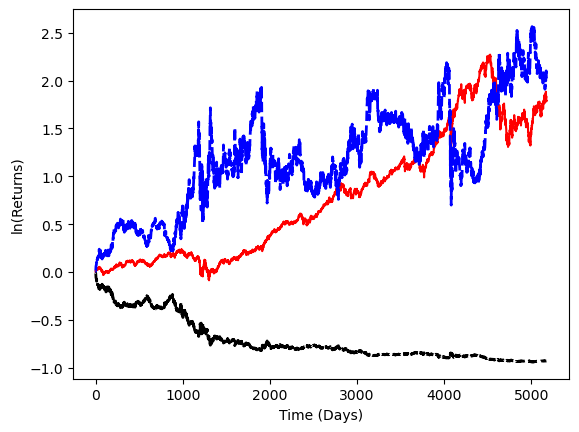

In [191]:
cumulative_returns_strat = calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2, invert=False)

cumulative_returns_strat_invert = calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2,
                                                               invert=True)

plt.plot(cumulative_returns, color='red')
plt.plot(cumulative_returns_strat, color='black', linestyle='--', linewidth=2)
plt.plot(cumulative_returns_strat_invert, color='blue', linestyle='--', linewidth=2)
plt.ylabel('ln(Returns)')
plt.xlabel('Time (Days)')
plt.show()